#IMPORTS

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

import copy
import os
import re
import math
import tarfile
import zipfile
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from urllib import request
import collections
import sklearn.metrics as sk_metrics
import matplotlib.pyplot as plt
import pickle

In [2]:
! pip install keras_tuner
import keras_tuner as kt

In [3]:
# In order to use key_to_index attribute from the embedding model
! pip install gensim==4.1.2
import gensim
import gensim.downloader as gloader

In [4]:
! pip install matplotlib==3.5.0

In [5]:
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
TRAINING = False
TRAINING_BEST = False

In [6]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)    
    
fix_random(42)

#PRE-PROCESSING

In [7]:
def download_dataset(download_path: str, url: str):  # download dataset
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")


def extract_dataset(download_path: str, extract_path: str):  # extract dataset
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")


def encode_dataset(dataset_path: str, dataset_folder: str, debug: bool = True) -> (
        pd.DataFrame, int):  # dataset to dataframe
    dataframe_rows = []
    s_lengths_orig = []
    s_lengths_clean = []
    deleted = 0
    for index, file in tqdm(enumerate(sorted(os.listdir(dataset_path)))):
        file_name = os.path.join(dataset_path, file)
        with open(file_name) as f:
            lines = f.readlines()
        full_file = ''.join(lines)  # since lines is a list we use a single string called full_file

        full_file = re.sub(r'(\t\d+)', '', full_file)  # remove numbers from each lines of dataset
        full_file = re.sub(r'(\t)', ' ', full_file)  # replace \t with a space
        sentences = full_file.split('\n\n')
        for s in sentences:  # separate all words from their tags
            text = ''.join(re.findall(r'.+ ', s))
            labels = ''.join(re.findall(r' .+', s))
            labels = re.sub(r' (.+)', r'\1 ', labels)
            labels = re.sub('\n', ' ', labels)
            s_lengths_orig.append(len(labels.split(' ')))
            # split into train, val and test
            if index <= 100:
                split = 'train'
            elif 100 < index <= 150:
                split = 'val'
            else:
                split = 'test'

            if len(labels.split(' ')) <= 80 and (split == "train" or split =="val"):
                # create a single row of dataframe
                s_lengths_clean.append(len(labels.split(' ')))
                dataframe_row = {
                    "text": text,
                    "POStagging": labels,
                    "split": split,
                }
                dataframe_rows.append(dataframe_row)
            elif len(labels.split(' ')) > 80 and (split == "train" or split == "val"):
                deleted += 1
            
            if split == "test":
                dataframe_row = {
                    "text": text,
                    "POStagging": labels,
                    "split": split,
                }
                dataframe_rows.append(dataframe_row)

    print(f"We deleted {deleted} sentences from train!")
    print(f"The dataset has on average {np.mean(s_lengths_orig)} words per sentence")
    plt.title("Boxplot of word counts per sentence")
    plt.boxplot(s_lengths_orig)
    plt.show()
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text",
             "POStagging",
             "split"]]
    print("Max length of a sentence in validation and test")
    print(max(df[df["split"] == "val"]["POStagging"].str.split().str.len()))
    print(max(df[df["split"] == "test"]["POStagging"].str.split().str.len()))
    print("Number of elements exceeding the length of the train")
    print(len(df[df["split"]=="val"][df[df["split"] == "val"]["POStagging"].str.split().str.len() > 80]))
    print(len(df[df["split"]=="test"][df[df["split"] == "test"]["POStagging"].str.split().str.len() > 80]))
    dataframe_path = os.path.join(dataset_folder, "dependency_treebank_df.pkl")
    df.to_pickle(dataframe_path)
    return df, max(s_lengths_clean)


def create_dataset():
    dataset_folder = os.path.join(os.getcwd(), "Datasets")
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    dataset_path_zip = os.path.join(dataset_folder, "dependency_treebank.zip")
    download_dataset(dataset_path_zip, url)
    extract_dataset(dataset_path_zip, dataset_folder)
    dataset_path = os.path.join(dataset_folder, "dependency_treebank")
    df, max_seq_len = encode_dataset(dataset_path, dataset_folder)
    df['POStagging'] = df['POStagging'].str.lower()
    df['text'] = df['text'].str.lower()
    return df, max_seq_len


def create_trainable(dataset, value_to_key, max_seq_len, num_classes, label_tokenizer=None):
    text_ids = [[value_to_key[word] for word in sen.split()] for sen in dataset['text']]
    x_train = []
    y_train = []
    label_tokenizer = {} if label_tokenizer == None else label_tokenizer

    one_hot_idx = 1
    label_tokenizer["<PAD>"] = [1 if i == 0 else 0 for i in range(num_classes)]
    for sen, tagging in zip(text_ids, dataset["POStagging"]):
        tmp = [0] * (max_seq_len - len(sen)) + sen
        x_train.append(tmp)

        for label in tagging.split():
            try:
                check_label = label_tokenizer[label]
            except KeyError:
                label_tokenizer[label] = [1 if i == one_hot_idx else 0 for i in range(num_classes)]
                one_hot_idx += 1

        tmp = [[0] * num_classes] * (max_seq_len - len(sen)) + [label_tokenizer[e] for e in tagging.split()]
        y_train.append(tmp)
    return np.array(x_train), np.array(y_train), label_tokenizer


def get_num_classes(dataset):
    return len(np.unique(''.join(dataset["POStagging"]).split())) + 1  # +1 for the padding

#########################################

try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/NLP/Assignment1"
    
    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)
    
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
    %pwd

# To download uncomment the following: 
# download_data('dataset')

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/NLP/Assignment1  exists.

Colab: Changing directory to  /content/gdrive/My Drive/NLP/Assignment1
/content/gdrive/My Drive/NLP/Assignment1


#CLASSES

##Tokenizer

In [8]:
class Tokenizer(object):
    def __init__(self, dataset_sentences, embedding_dim, glove_dict, glove_matrix):
        self.embedding_matrix = None
        self.value_to_key = {}
        self.value_to_key_new = {}
        self.key_to_value = {}
        self.num_unique_words = 0
        self.dataset_sentences = dataset_sentences
        self.embedding_dim = embedding_dim
        self.glove_dict = glove_dict
        self.glove_matrix = glove_matrix
        self.unique_words = set()

    def get_val_to_key(self):
        return copy.deepcopy(self.value_to_key)

    def tokenize(self):
        self.value_to_key_new = {}
        unique_words = set()
        for sen in self.dataset_sentences:
            for w in sen.split():
                unique_words.add(w)  # get se of unique words
        new_unique = unique_words - self.unique_words
        for i, word in enumerate(new_unique):
            if self.embedding_matrix is not None:
                self.key_to_value[i + len(self.embedding_matrix)] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i + len(self.embedding_matrix)
            else:
                self.key_to_value[i] = word  # build two dictionaries for key value correspondence
                self.value_to_key[word] = i
            self.value_to_key_new[word] = i

        self.num_unique_words = len(new_unique)
        self.unique_words = self.unique_words | new_unique  # union of unique words and new unique words

    def __build_embedding_matrix_glove(self):
        oov_words = []
        tmp_embedding_matrix = np.zeros((self.num_unique_words, self.embedding_dim)) #dtype=np.float32
        len_old_emb_matrix = len(self.embedding_matrix) if self.embedding_matrix is not None else 0
        for word, idx in tqdm(self.value_to_key_new.items()):
            try:
                embedding_vector = self.glove_matrix[self.glove_dict[word]]
                tmp_embedding_matrix[idx] = embedding_vector
            except (KeyError, TypeError):
                oov_words.append((word, idx + len_old_emb_matrix))
        
        if self.embedding_matrix is not None:
            self.embedding_matrix = np.vstack((self.embedding_matrix, tmp_embedding_matrix))

        else:
            self.embedding_matrix = copy.deepcopy(tmp_embedding_matrix)
        return oov_words

    def build_embedding_matrix(self):
        oov_words = self.__build_embedding_matrix_glove()
        for word, idx in oov_words:
            neighbour_words = []
            for sen in self.dataset_sentences:  # look for word in sentence
                for i, wanted_word in enumerate(sen):
                    if wanted_word == word:
                        neighbour_words.append(sen[i - 1])  # append previous word in list of neighbours
                        neighbour_words.append(sen[i + 1])  # append next word in list of neighbours
            avg_matrix = np.zeros((len(neighbour_words), self.embedding_dim))  # initialize matrix of avgs

            length_in_vocab = 0  # to check if neighbours are OOV
            for i, el in enumerate(neighbour_words):
                try:
                    avg_matrix[i] = self.embedding_matrix[self.value_to_key[el]]  # check not OOV
                    length_in_vocab += 1  # we don't want to use the zero columns of avg_matrix
                except (KeyError, TypeError):  # the model doesn't exist
                    pass
            if length_in_vocab == 0:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_dim)
            else:
                embedding_vector = np.mean(avg_matrix[:length_in_vocab], axis=0)
            self.embedding_matrix[idx] = embedding_vector
        return copy.deepcopy(self.embedding_matrix)

##Model

In [9]:
class Model(object):
    def __init__(self, model_type, compile_info, value_to_key, embedding_dim, max_seq_len, num_labels,
                 embedding_matrix, num_recurrent_units, l2_reg):

        self.compile_info = compile_info
        self.value_to_key = value_to_key
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.num_labels = num_labels
        self.embedding_matrix = embedding_matrix
        self.num_recurrent_units = num_recurrent_units
        self.l2_reg = l2_reg
        self.name = model_type

        if 'baseline' == model_type:
            self.model = self.create_LSTM()
        elif 'gru' == model_type:
            self.model = self.create_GRU()
        elif 'two_lstm' == model_type:
            self.model = self.create_two_LSTM()
        else:
            self.model = self.create_two_Dense()


    def create_LSTM(self) -> keras.Model:
        bidirect_model = keras.models.Sequential()

        inputs = keras.layers.Input(shape=(None,))
        x = layers.Embedding(input_dim=len(self.value_to_key.keys()) + 1,
                                            output_dim=self.embedding_dim,
                                            mask_zero = True,
                                            input_length=self.max_seq_len,
                                            weights=[self.embedding_matrix],
                                            trainable=False
                                            )(inputs)

        x = layers.Bidirectional(layers.LSTM(self.num_recurrent_units, return_sequences=True, kernel_regularizer=l2(self.l2_reg)))(x)
        outputs = layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax"))(x)
        bidirect_model = keras.Model(inputs=inputs, outputs=outputs)
        bidirect_model.compile(**self.compile_info)
        bidirect_model.summary()
        return bidirect_model

    def create_GRU(self) -> keras.Model:
        gru = keras.models.Sequential()
        gru.add(layers.Embedding(input_dim=len(self.value_to_key.keys()) + 1,
                                 output_dim=self.embedding_dim,
                                 input_length=self.max_seq_len,
                                 mask_zero=True,
                                 weights=[self.embedding_matrix],
                                 trainable=False
                                 ))

        gru.add(layers.GRU(self.num_recurrent_units, return_sequences=True, kernel_regularizer=l2(self.l2_reg)))
        gru.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        gru.compile(**self.compile_info)
        gru.summary()
        return gru

    def create_two_LSTM(self) -> keras.Model:
        lstm = keras.models.Sequential()
        lstm.add(layers.Embedding(input_dim=len(self.value_to_key.keys()) + 1,
                                  output_dim=self.embedding_dim,
                                  input_length=self.max_seq_len,
                                  mask_zero=True,
                                  weights=[self.embedding_matrix],
                                  trainable=False
                                  ))

        lstm.add(layers.Bidirectional(layers.LSTM(self.num_recurrent_units, return_sequences=True, kernel_regularizer=l2(self.l2_reg))))
        lstm.add(layers.LSTM(self.num_recurrent_units//2, return_sequences=True))
        lstm.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        lstm.compile(**self.compile_info)
        lstm.summary()
        return lstm

    def create_two_Dense(self) -> keras.Model:
        lstm = keras.models.Sequential()
        lstm.add(layers.Embedding(input_dim=len(self.value_to_key.keys()) + 1,
                                  output_dim=self.embedding_dim,
                                  input_length=self.max_seq_len,
                                  mask_zero=True,
                                  weights=[self.embedding_matrix],
                                  trainable=False
                                  ))
        lstm.add(layers.Bidirectional(layers.LSTM(self.num_recurrent_units, return_sequences=True, kernel_regularizer=l2(self.l2_reg))))
        lstm.add(layers.TimeDistributed(layers.Dense(self.num_recurrent_units*2, activation="relu")))
        lstm.add(layers.TimeDistributed(layers.Dense(self.num_labels, activation="softmax")))
        lstm.compile(**self.compile_info)
        lstm.summary()
        return lstm

    def show_history(self, history: keras.callbacks.History):

        history_data = history.history
        print("Displaying the following history keys: ", history_data.keys())

        for key, value in history_data.items():
            if not key.startswith('val'):
                fig, ax = plt.subplots(1, 1)
                ax.set_title(key)
                ax.plot(value)
                if 'val_{}'.format(key) in history_data:
                    ax.plot(history_data['val_{}'.format(key)])
                else:
                    print("Couldn't find validation values for metric: ", key)

                ax.set_ylabel(key)
                ax.set_xlabel('epoch')
                ax.legend(['train', 'val'], loc='best')

        plt.show()

    def train_model(self,
                    x_train: np.ndarray,
                    y_train: np.ndarray,
                    x_val: np.ndarray,
                    y_val: np.ndarray,
                    training_info: dict):
        print("Start training! \nParameters: {}".format(training_info))
        history = self.model.fit(x=x_train, y=y_train,
                                 validation_data=(x_val, y_val),
                                 shuffle=True,
                                 **training_info)
        print("Training completed! Showing history...")

        self.show_history(history)

#MAIN

Extracting dataset... (it may take a while...)
Extraction completed!


199it [00:00, 503.46it/s]


We deleted 7 sentences from train!
The dataset has on average 25.037812979049566 words per sentence


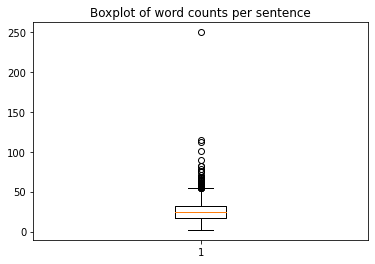

Max length of a sentence in validation and test
75
58
Number of elements exceeding the length of the train
0
0


In [10]:
df, max_seq_len = create_dataset()


try:
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'rb') as f:
        emb_model = pickle.load(f)
except Exception:
    emb_model = gloader.load(f"glove-wiki-gigaword-{EMBEDDING_SIZE}")
    with open(f"glove-{EMBEDDING_SIZE}.pkl", 'wb') as f:
        pickle.dump(emb_model, f)

glove_dict = emb_model.key_to_index
glove_matrix = emb_model.vectors


try:
    with open("emb_mat.pkl", 'rb') as f:
        v4_matrix = pickle.load(f)
    with open("val_to_key.pkl", 'rb') as f:
        v4_val_to_key = pickle.load(f)
except Exception:
    tokenizer = Tokenizer(df[df['split'] == 'train']['text'], EMBEDDING_SIZE, glove_dict, glove_matrix)
    tokenizer.tokenize()
    v2_matrix = tokenizer.build_embedding_matrix()
    tokenizer.dataset_sentences = df[df['split'] == 'val']['text']
    tokenizer.tokenize()
    v3_matrix = tokenizer.build_embedding_matrix()
    tokenizer.dataset_sentences = df[df['split'] == 'test']['text']
    tokenizer.tokenize()
    v4_matrix = tokenizer.build_embedding_matrix()
    v4_val_to_key = tokenizer.get_val_to_key()
    with open(f"emb_mat.pkl", 'wb') as f:
        pickle.dump(v4_matrix, f)
    with open(f"val_to_key.pkl", 'wb') as f:
        pickle.dump(v4_val_to_key, f)

v4_val_to_key.update((x, y+1) for x, y in v4_val_to_key.items())

num_classes = get_num_classes(df[df['split'] == 'train'])
x_train, y_train, tok = create_trainable(df[df['split'] == 'train'], 
                                         v4_val_to_key, 
                                         max_seq_len,
                                         num_classes=num_classes)
x_val, y_val, tok = create_trainable(df[df['split'] == 'val'], 
                                     v4_val_to_key, 
                                     max_seq_len, 
                                     num_classes=num_classes, 
                                     label_tokenizer=tok)
x_test, y_test, tok = create_trainable(df[df['split'] == 'test'], 
                                       v4_val_to_key,
                                       max_seq_len, 
                                       num_classes=num_classes, 
                                       label_tokenizer=tok)


In [11]:
print(np.unique(''.join(df['POStagging']).split()))
print("Unique classes ",len(np.unique(''.join(df['POStagging']).split())))

vali = df[df['split']=='val']
traini = df[df['split']=='train']

uni_vali = set(''.join(vali['text']).split())
uni_traini = set(''.join(traini['text']).split())

diff = uni_vali - (uni_traini & uni_vali)


print()
print(f"[Training] unique words: \t{len(uni_traini)}")
print(f"[Training & Val] unique words: \t{len(uni_traini & uni_vali)}")
print(f"[Val] unique word: \t{len(uni_vali)}  (val tolale)") 
print(f"Difference [Val - (Training & Val)] unique words: \t{len(diff)}  (val che non sta in train)")

uni_glove = set(glove_dict.keys())
diff_glove = uni_vali - (uni_vali & uni_glove)
print(f"Difference [Val - (Val & Glove)] unique words: \t{len(diff_glove)}  (val che non sta in glove)")
print(f"Word from Val not seen by Train: {(len(diff_glove) + len(diff))*100/len(uni_vali):.2F}%")
print()

for i,  oov in enumerate(diff_glove):
    if i < 10:
        print(oov)

df2 = df[df['POStagging'].str.contains('wp\$')]
df2[df2['split']=='test']

['#' '$' "''" ',' '-lrb-' '-rrb-' '.' ':' '``' 'cc' 'cd' 'dt' 'ex' 'fw'
 'in' 'jj' 'jjr' 'jjs' 'ls' 'md' 'nn' 'nnp' 'nnps' 'nns' 'pdt' 'pos' 'prp'
 'prp$' 'rb' 'rbr' 'rbs' 'rp' 'sym' 'to' 'uh' 'vb' 'vbd' 'vbg' 'vbn' 'vbp'
 'vbz' 'wdt' 'wp' 'wp$' 'wrb']
Unique classes  45

[Training] unique words: 	7355
[Training & Val] unique words: 	2884
[Val] unique word: 	5322  (val tolale)
Difference [Val - (Training & Val)] unique words: 	2438  (val che non sta in train)
Difference [Val - (Val & Glove)] unique words: 	212  (val che non sta in glove)
Word from Val not seen by Train: 49.79%

sulfur-dioxide
29year
money-market
continuingly
above-market
47.125
land-idling
3\/4
six-packs
20-stock


,text,POStagging,split
3518,"coleco industries inc. , a once high-flying to...","nnp nnps nnp , dt rb jj nn nn wp$ nn jj in $ c...",test
3523,but coleco bounced back with the introduction ...,"cc nnp vbd rp in dt nn in dt nnp nnp nns , wp$...",test
3742,absorbed in doling out `` feeding frenzy 's ''...,"vbn in vbg rp `` nnp nnp pos '' nns , dt nns v...",test
3874,"still , usx fared better than other major stee...","rb , nnp vbd rbr in jj jj nns , vbg jjr in nn ...",test


In [12]:
print(glove_matrix[glove_dict["the"]])
ind = v4_val_to_key["the"]-1
print(v4_matrix[ind])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

#TRAIN VARIOUS MODELS

In [13]:
compile_info = {
    'optimizer': keras.optimizers.Nadam(learning_rate=1e-2),
    'loss': 'categorical_crossentropy',
    'metrics': ['acc']
}

training_info = {
    'verbose': 1,
    'epochs': 10,
    'batch_size': BATCH_SIZE,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                patience=4,
                                                restore_best_weights=True)]
}

model_params = {
    'compile_info': compile_info,
    'value_to_key': v4_val_to_key,
    'embedding_dim': EMBEDDING_SIZE,
    'max_seq_len': max_seq_len,
    'num_labels': num_classes,
    'embedding_matrix': np.vstack((np.zeros((1, EMBEDDING_SIZE)),
                       v4_matrix)),
    'num_recurrent_units': 32,
    'l2_reg': 1e-4
}

prediction_info = {
    'batch_size': BATCH_SIZE,
    'verbose': 1
}


model_names = ['baseline', 'gru', 'two_lstm', 'two_dense']
if TRAINING:
    models = []
    histories = []
    for m_name in model_names:
        model = Model(m_name, **model_params)
        history = model.train_model(x_train=x_train, y_train=y_train,
                                    x_val=x_val, y_val=y_val, training_info=training_info)
        model.model.save(m_name)
        models.append(model.model)
        histories.append(history)
else:
    models = [keras.models.load_model(m) for m in model_names]

#EVALUATION

In [14]:
def calculate_f1(model, x, y_true):
    #start prediction
    print('Predicting on {} samples'.format(x.shape[0]))
    y_pred = model.predict(x, **prediction_info)

    # from one hot to label index
    y_pred_list = []
    y_true_list = []

    punctuation = ['#', '$', "''", ',', '-lrb-', '-rrb-', '.', ':', '``']
    punctuation_toks = [tok[punct] for punct in punctuation]

    for i, sen in enumerate(y_pred):
        for w_pred, w_true in zip(y_pred[i], y_true[i]):
            if np.argmax(w_true) not in punctuation and np.argmax(w_true)!=0:
                y_pred_list.append(np.argmax(w_pred)) 
                y_true_list.append(np.argmax(w_true))

    return sk_metrics.f1_score(y_true_list, y_pred_list, average='macro')
    
#print(calculate_f1(models[0], x_test, y_test))


Predicting on 1284 samples
21/21 [==============================] - 3s 39ms/step
Predicting on 1284 samples
21/21 [==============================] - 1s 16ms/step
Predicting on 1284 samples
21/21 [==============================] - 4s 50ms/step
Predicting on 1284 samples
21/21 [==============================] - 3s 36ms/step
Predicting on 644 samples
11/11 [==============================] - 0s 34ms/step
Predicting on 644 samples
11/11 [==============================] - 0s 15ms/step
Predicting on 644 samples
11/11 [==============================] - 1s 53ms/step
Predicting on 644 samples
11/11 [==============================] - 0s 36ms/step


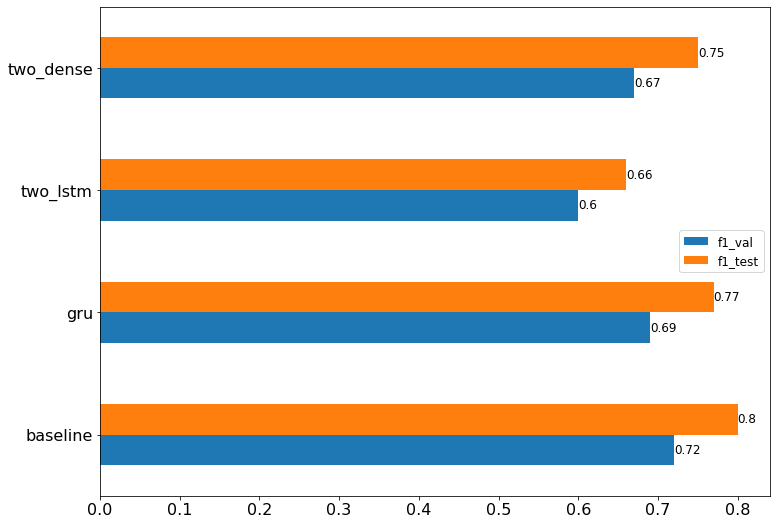

In [15]:
f1s_val = [round(calculate_f1(m, x_val, y_val), 2) for m in models]
f1s_test = [round(calculate_f1(m, x_test, y_test), 2) for m in models]
df = pd.DataFrame({'f1_val': f1s_val,
                   'f1_test': f1s_test},index=model_names)
ax = df.plot.barh(figsize=(12, 9), fontsize=16)
ax.legend(loc='center right', fontsize=12) 
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, labels,
                          clf_name=None, normalize='true', figsize=(15, 15)):
    """
        This function calculates and plots with matplotlib the confusion matrix
        for some given y_pred, y_true, is slightly different from sklearn's twin
        The function is created with the intent of readability and compactness

    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    labels : dictionary to map numbers to labels
    clf_name : string, classifier name
    normalize : {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    figsize : tuple, figure size in inches

    return: None
    """

    assert len(y_true) == len(y_pred), "y_true and y_pred have to have the same length"
    conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize, labels = list(labels.keys()))
    num_classes = len(labels)
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("xkcd:white")  # white background for dark themes
    ax.imshow(conf_mat, cmap=plt.get_cmap("RdYlGn"))

    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))

    ax.set_xticklabels([labels[i] for i in range(num_classes)])
    ax.set_yticklabels([labels[i] for i in range(num_classes)])

    [ax.text(j, i, f"{conf_mat[i, j]:.2F}", va="center", ha="center")
     for i in range(len(conf_mat)) for j in range(len(conf_mat[0]))]

    plt.title(f"Confusion Matrix {'' if clf_name is None else f'for {clf_name}'}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

Confusion matrices over validation set: 
Predicting on 1284 samples
21/21 [==============================] - 1s 42ms/step


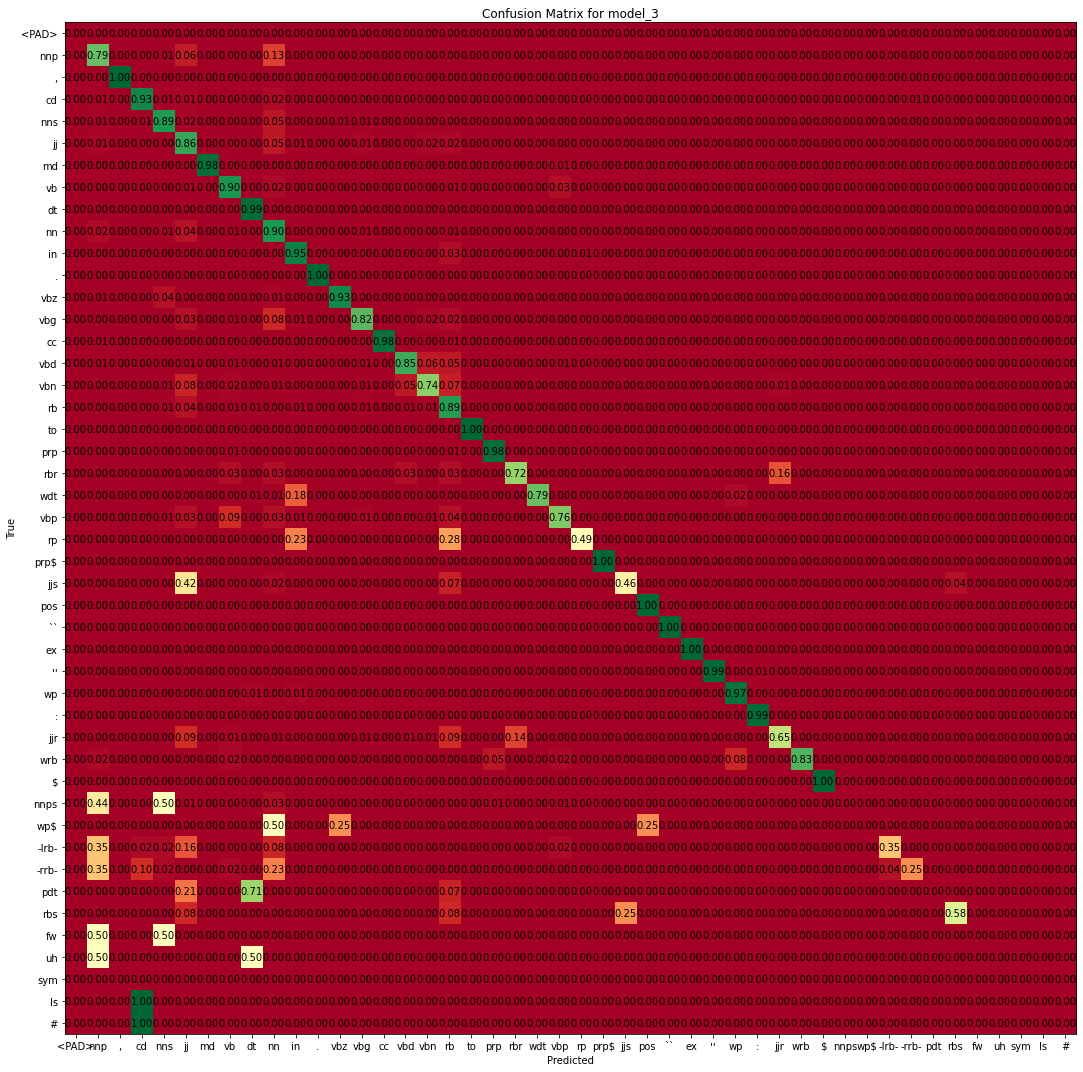

Predicting on 1284 samples
21/21 [==============================] - 0s 18ms/step


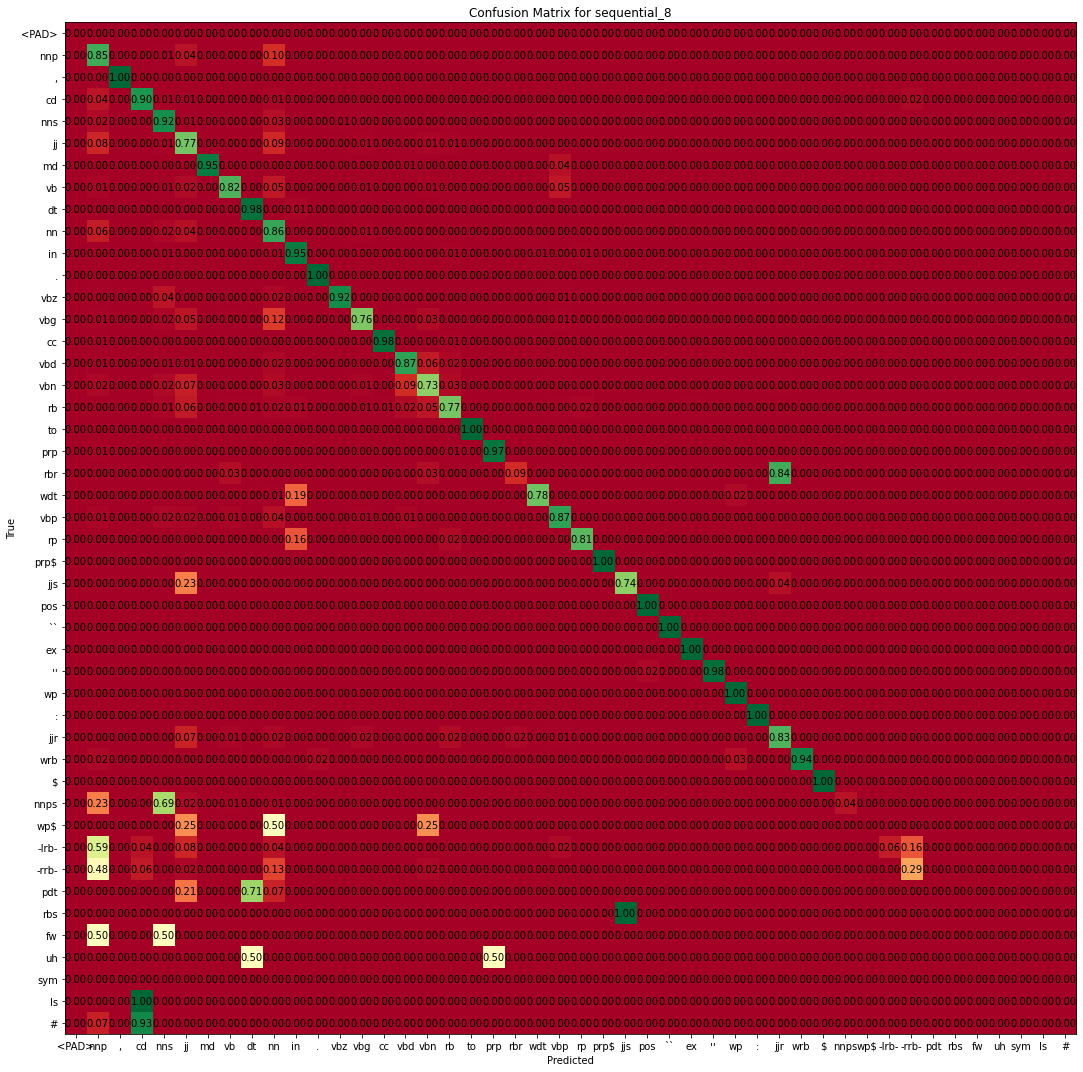

Predicting on 1284 samples
21/21 [==============================] - 1s 51ms/step


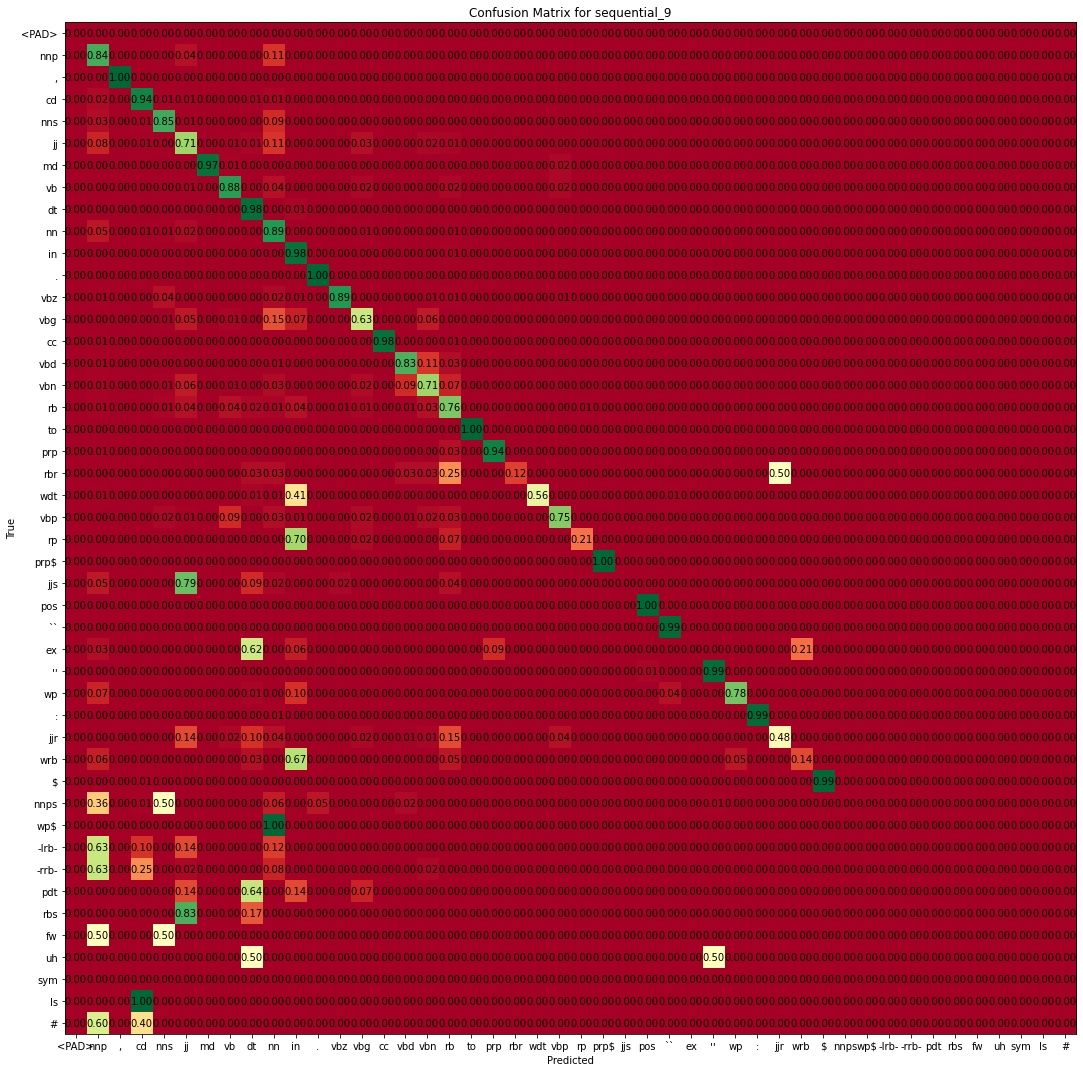

Predicting on 1284 samples
21/21 [==============================] - 1s 36ms/step


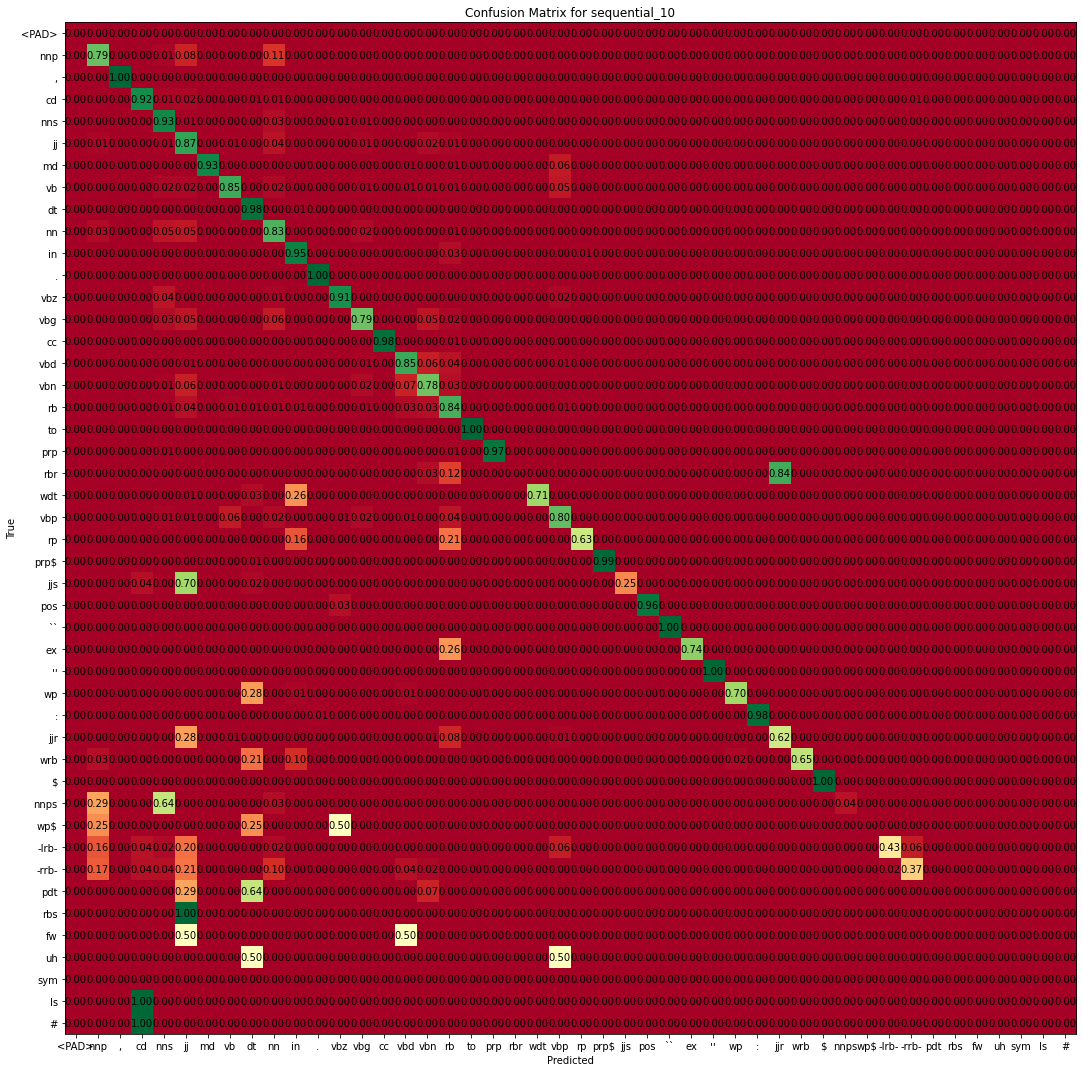

[None, None, None, None]

In [17]:
print("Confusion matrices over validation set: ")

def calculate_conf_mat(model, x, y_true):
    #start prediction
    print('Predicting on {} samples'.format(x.shape[0]))
    y_pred = model.predict(x, **prediction_info)

    # from one hot to label index
    y_pred_list = []
    y_true_list = []

    labels_dict = {np.argmax(val):key for key,val in tok.items()}

    for i, sen in enumerate(y_pred):
        for w_pred, w_true in zip(y_pred[i], y_true[i]):
            if np.argmax(w_true)!=0:
                y_pred_list.append(np.argmax(w_pred)) 
                y_true_list.append(np.argmax(w_true))
    plot_confusion_matrix(y_true_list, y_pred_list, labels=labels_dict, clf_name=model.name)


[calculate_conf_mat(m, x_val, y_val) for m in models]


In [36]:
%cd '..'
! ls


/content/gdrive/My Drive/NLP/Assignment1
baseline  emb_mat.pkl	 gru	   LSTMtuner  two_lstm
Datasets  glove-100.pkl  GRUtuner  two_dense  val_to_key.pkl


In [ ]:
from keras import regularizers

%cd "LSTMtuner"

def tuner_LSTM(hp) -> keras.Model:
    bidirect_model = keras.models.Sequential()

    inputs = keras.layers.Input(shape=(None,))
    x = layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                                        output_dim=EMBEDDING_SIZE,
                                        mask_zero = True,
                                        input_length=max_seq_len,
                                        weights=[np.vstack((np.zeros((1, EMBEDDING_SIZE)), v4_matrix))],
                                        trainable=False
                                        )(inputs)
    x = layers.Bidirectional(layers.LSTM(hp.Choice('units', [32, 64, 128]), kernel_regularizer = regularizers.l2(hp.Choice("l2", [1e-5, 1e-4, 1e-3])), return_sequences=True))(x)
    outputs = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"))(x)
    bidirect_model = keras.Model(inputs=inputs, outputs=outputs)
    bidirect_model.compile(optimizer = keras.optimizers.Nadam(learning_rate=1e-2), metrics = ['acc'], loss = 'categorical_crossentropy')
    return bidirect_model


tune_LSTM = kt.BayesianOptimization(
    tuner_LSTM,
    objective='val_acc',
    max_trials = 15)
tune_LSTM.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
tune_LSTM.results_summary()
best_model_LSTM = tune_LSTM.get_best_models()[0]

[Errno 2] No such file or directory: 'LSTMtuner'
/content/gdrive/My Drive/NLP/Assignment1/LSTMtuner

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |128               |?                 
l2                |1e-05             |?                 

Epoch 1/5
 3/62 [>.............................] - ETA: 18s - loss: 1.0105 - acc: 0.1078

In [25]:
%cd ".."
%cd "GRUtuner"

def tuner_GRU(hp) -> keras.Model:
    gru = keras.models.Sequential()
    gru.add(layers.Embedding(input_dim=len(v4_val_to_key.keys()) + 1,
                              output_dim=EMBEDDING_SIZE,
                              input_length=max_seq_len,
                              mask_zero=True,
                              weights=[np.vstack((np.zeros((1, EMBEDDING_SIZE)),v4_matrix))],
                              trainable=False
                              ))
    gru.add(layers.GRU(hp.Choice('units', [32, 64, 128]), return_sequences=True, kernel_regularizer = regularizers.l2(hp.Choice("l2", [1e-5, 1e-4, 1e-3]))))
    gru.add(layers.TimeDistributed(layers.Dense(num_classes, activation="softmax")))
    gru.compile(optimizer = keras.optimizers.Nadam(learning_rate=1e-2), metrics = ['acc'], loss = 'categorical_crossentropy')
    return gru

tune_GRU =kt.BayesianOptimization(
    tuner_GRU,
    objective='val_acc',
    max_trials=15)
tune_GRU.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
tune_GRU.results_summary()
best_model_GRU = tune_GRU.get_best_models()[0]

Trial 13 Complete [00h 01m 11s]
val_acc: 0.8992897868156433

Best val_acc So Far: 0.9049779772758484
Total elapsed time: 00h 16m 18s

Search: Running Trial #14

Hyperparameter    |Value             |Best Value So Far 
units             |64                |64                
l2                |1e-05             |1e-05             
loss              |categorical_cro...|categorical_cro...

Epoch 1/5
61/62 [============================>.] - ETA: 0s - loss: 0.3561 - acc: 0.7036

KeyboardInterrupt: ignored

In [14]:
# vedere class imbalance 
# vedere sliding window

#TRAIN AND EVALUATE BEST MODELS

In [ ]:
best_model_compile_info = {
    'optimizer': keras.optimizers.Nadam(learning_rate=1e-2),
    'loss': 'categorical_crossentropy',
    'metrics': ['acc']
}

training_info = {
    'verbose': 1,
    'epochs': 30,
    'batch_size': BATCH_SIZE,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                patience=4,
                                                restore_best_weights=True)]
}

best_model_params = {
    'compile_info': compile_info,
    'value_to_key': v4_val_to_key,
    'embedding_dim': EMBEDDING_SIZE,
    'max_seq_len': max_seq_len,
    'num_labels': num_classes,
    'embedding_matrix': np.vstack((np.zeros((1, EMBEDDING_SIZE)),
                       v4_matrix)),
    'num_recurrent_units': 32,
    'l2_reg': 1e-4
}

best_model_names = ['baseline', 'gru']
if TRAINING_BEST:
    best_models = []
    histories = []
    for m_name in model_names:
        model = Model(m_name, **model_params)
        history = model.train_model(x_train=x_train, y_train=y_train,
                                    x_val=x_val, y_val=y_val, training_info=training_info)
        model.model.save(m_name)
        best_models.append(model.model)
        histories.append(history)
else:
    models = [keras.models.load_model(m) for m in model_names]